# Classify Documents

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load Data
The next cell will load embeddings generated in notebook [01-get-embeddings.ipynb](./01-get-embeddings.ipynb).

In [3]:
import pandas as pd

df_orig = pd.read_csv("../data/bbc-news-data-embedding.csv", delimiter='\t', index_col=False)

In [4]:
df = df_orig.copy()
df

,category,filename,title,content,embedding
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.0012276918860152364, 0.00733763724565506, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[0.0009311728645116091, 0.014099937863647938, ..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.010487922467291355, 0.009665092453360558, ..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[0.0111119095236063, 0.004624682944267988, -0...."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.0021637482568621635, 0.005410161800682545,..."
...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,"[0.007671569474041462, 0.00624304823577404, -0..."
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,"[0.0026338498573750257, 0.015989987179636955, ..."
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,"[0.007126151118427515, 0.008495588786900043, -..."
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,"[0.002447678940370679, 0.006076449993997812, -..."


In [5]:
# drop rows with NaN
df.dropna(inplace=True)
len(df)

2217

## Classify documents with their embeddings
ref: https://github.com/openai/openai-cookbook/blob/main/examples/Classification_using_embeddings.ipynb

In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# convert string to array
df["embedding"] = df['embedding'].apply(eval).apply(np.array)  

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2217 entries, 0 to 2223
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   2217 non-null   object
 1   filename   2217 non-null   object
 2   title      2217 non-null   object
 3   content    2217 non-null   object
 4   embedding  2217 non-null   object
dtypes: object(5)
memory usage: 103.9+ KB


In [8]:
X = df['embedding']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y) 

# reshape X into 2D array
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

## Fit a model with `XGBoost`

In [23]:
from xgboost import XGBClassifier
import pickle

TRAIN = False
LOAD = True

# filename for trained model
fname = '../output/models/xgb.pkl'

if TRAIN: 
    # create model instance
    xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=1, objective='multi:softprob')
    # fit model
    xgb.fit(X_train, y_train)

    # save the model to disk
    with open(fname, "wb") as f:
        pickle.dump(xgb, f)
 
# load the model from disk
if LOAD:
    with open(fname, "rb") as f:
        xgb = pickle.load(f)

# predict
preds = xgb.predict(X_test)
probas = xgb.predict_proba(X_test)

# report
report = classification_report(y_test, preds)
print(report)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:07] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

               precision    recall  f1-score   support

     business       0.92      0.92      0.92       168
entertainment       0.94      0.93      0.93       127
     politics       0.90      0.90      0.90       137
        sport       0.98      0.98      0.98       168
         tech       0.92      0.93      0.93       132

     accuracy                           0.93       732
    macro avg       0.93      0.93      0.93       732
 weighted avg       0.93      0.93      0.93       732



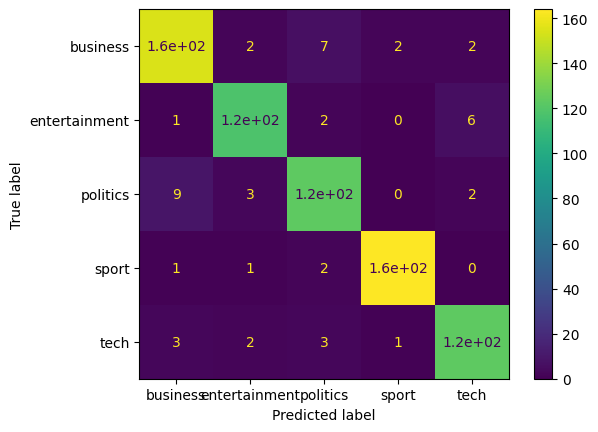

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot()


## Save predictions

In [102]:
y_test_pred = pd.DataFrame()
y_test_pred['category'] = y_test
y_test_pred['prediction'] = preds
y_test_pred

,category,prediction
252,business,business
1414,sport,sport
567,entertainment,entertainment
1460,sport,sport
775,entertainment,tech
...,...,...
421,business,business
1987,tech,tech
273,business,business
1047,politics,politics


In [101]:
df_test_result = pd.concat([df, y_test_pred.drop(columns='category')], axis=1, join="inner")
df_test_result.shape
df_test_result

(732, 6)

,category,filename,title,content,embedding,prediction
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[0.0009311728645116091, 0.014099937863647938, ...",business
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.0021637482568621635, 0.005410161800682545,...",business
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,"[0.008323440328240395, 0.014594526030123234, -...",business
13,business,014.txt,Telegraph newspapers axe 90 jobs,The Daily and Sunday Telegraph newspapers are...,"[-0.001993480371311307, 0.0038063114043325186,...",business
14,business,015.txt,Air passengers win new EU rights,Air passengers who are unable to board their ...,"[0.01202255580574274, 0.0024986255448311567, -...",business
...,...,...,...,...,...,...
2209,tech,386.txt,Video phones act as dating tools,"Technologies, from e-mail, to net chatrooms, ...","[-0.0021125166676938534, -0.003049303079023957...",tech
2212,tech,389.txt,Mobile multimedia slow to catch on,There is no doubt that mobile phones sporting...,"[0.007488378323614597, 0.007830777205526829, -...",tech
2213,tech,390.txt,Anti-spam laws bite spammer hard,The net's self-declared spam king is seeking ...,"[-0.002103055827319622, 0.00393986189737916, -...",tech
2216,tech,393.txt,Savvy searchers fail to spot ads,Internet search engine users are an odd mix o...,"[0.00633224518969655, 0.007613884285092354, -0...",tech


## Save Results

In [ ]:
# Save results
fname = '../output/predictions.csv'
df_test_result.to_csv(fname, sep='\t')

## Wrong Predictions

In [100]:
df_wrong_predictions = df_test_result[df_test_result['category'] != df_test_result['prediction']]
df_wrong_predictions

,category,filename,title,content,embedding,prediction
105,business,106.txt,Golden rule 'intact' says ex-aide,Chancellor Gordon Brown will meet his golden ...,"[0.006964212749153376, 0.0015263919485732913, ...",politics
212,business,213.txt,US bank boss hails 'genius' Smith,US Federal Reserve chairman Alan Greenspan ha...,"[0.0021459858398884535, 0.0036910325288772583,...",entertainment
226,business,227.txt,Call to save manufacturing jobs,The Trades Union Congress (TUC) is calling on...,"[0.0012122669722884893, 0.0076951221562922, -0...",politics
235,business,236.txt,Card fraudsters 'targeting web',New safeguards on credit and debit card payme...,"[7.788832590449601e-05, 0.016654228791594505, ...",tech
240,business,241.txt,G7 backs Africa debt relief plan,G7 finance ministers have backed plans to wri...,"[-0.0027972061652690172, 0.013444329611957073,...",politics
241,business,242.txt,Q&A: Malcolm Glazer and Man Utd,The battle for control of Manchester United h...,"[0.002724364399909973, 0.004842962138354778, -...",sport
254,business,255.txt,Call to overhaul UK state pension,The UK pension system has been branded inadeq...,"[0.004907403141260147, 0.0119895339012146, -0....",politics
292,business,293.txt,Glazer makes new Man Utd approach,Malcolm Glazer has made a fresh approach to b...,"[-0.0023372862488031387, 0.006699692457914352,...",sport
387,business,388.txt,Venezuela identifies 'idle' farms,Venezuelan authorities have identified more t...,"[0.006353371310979128, 0.014112972654402256, -...",politics
412,business,413.txt,EC calls truce in deficit battle,The European Commission (EC) has called a tru...,"[0.003549534361809492, 0.005724851507693529, -...",politics
